In [1]:
import calendar
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime
from dateutil import parser

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle

from xgboost import XGBRegressor, DMatrix

import warnings

warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (11.7, 8.27)})

### Load file here

In [2]:
dat = pd.read_csv("../cleaned_data.csv")

.

In [3]:
dat = dat.loc[:, "Access":]

In [4]:
dat

,Access,DMA,Date Aired,Estimate,GRP,Impressions,Length,Market,Media,Spot Cost,Spot Type,Station ID,Time Aired,DOW,daypart
0,30GD,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,0.0,INV,168,00:05:00,Monday,Late Night
1,30GD,900,2019-02-25,Q119,0.000,0.0,30,National Network,TV,48.0,INV,37,00:05:00,Monday,Late Night
2,30SR,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,72.0,INV,25,00:05:00,Monday,Late Night
3,30BP,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,120.0,INV,182,00:08:00,Monday,Late Night
4,30BP,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,0.0,INV,256,00:10:00,Monday,Late Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683352,30TN,900,2019-01-27,Q119,0.000,NaN,30,Cable,TV,0.0,INV,75,23:50:00,Sunday,Late Fringe
683353,30DP,900,2019-01-27,Q119,0.016,NaN,30,Cable,TV,0.0,INV,161,23:51:00,Sunday,Late Fringe
683354,30TN,900,2019-01-27,Q119,0.000,NaN,30,Cable,TV,0.0,INV,245,23:52:00,Sunday,Late Fringe
683355,30TN,900,2019-01-27,Q119,0.016,NaN,30,Cable,TV,0.0,INV,31,23:53:00,Sunday,Late Fringe


In [5]:
dat.describe()

,GRP,Impressions,Length,Spot Cost,Station ID
count,683357.000000,503839.000000,683357.000000,683357.000000,683357.000000
mean,0.003117,3.445929,29.882916,81.776126,199.088294
std,0.015593,17.950122,1.320057,108.334736,110.998073
min,0.000000,0.000000,15.000000,0.000000,1.000000
25%,0.000000,0.000000,30.000000,48.000000,92.000000
50%,0.000000,0.000000,30.000000,56.000000,219.000000
75%,0.000000,0.000000,30.000000,96.000000,296.000000
max,0.864000,1046.400000,30.000000,5208.000000,379.000000


In [6]:
dat.dtypes

Access          object
DMA             object
Date Aired      object
Estimate        object
GRP            float64
Impressions    float64
Length           int64
Market          object
Media           object
Spot Cost      float64
Spot Type       object
Station ID       int64
Time Aired      object
DOW             object
daypart         object
dtype: object

In [7]:
dat["Date Aired"] = pd.to_datetime(dat["Date Aired"], format="%Y-%m-%d")
dat["Time Aired"] = pd.to_datetime(dat["Time Aired"], format="%H:%M:%S").dt.time

In [8]:
unseen = dat[(dat.Impressions.eq(0.0)) & (dat.GRP.eq(0.0))]
training = dat[dat.GRP > 0.0]

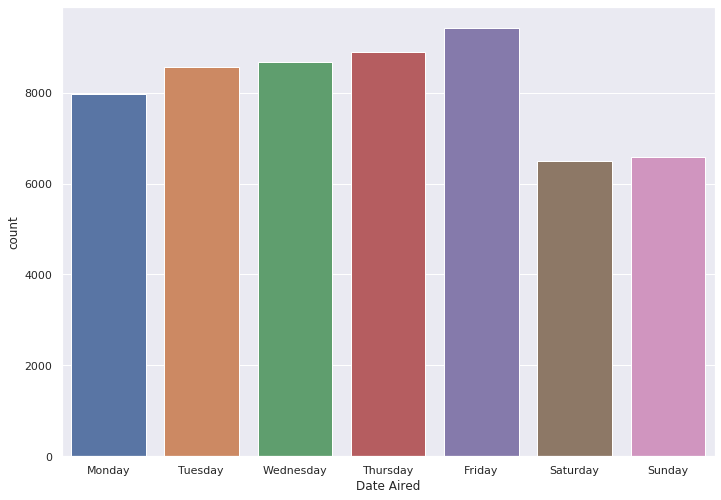

In [9]:
ax = sns.countplot(x=training["Date Aired"].dt.day_name(), data=dat)

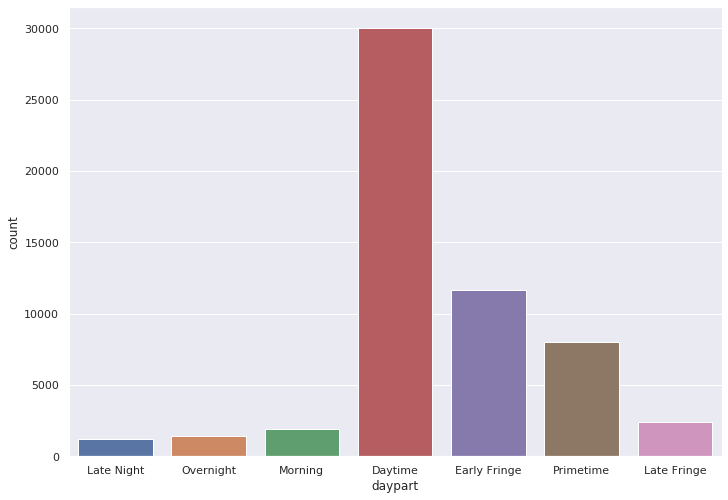

In [10]:
ax = sns.countplot(x=training["daypart"], data=dat)

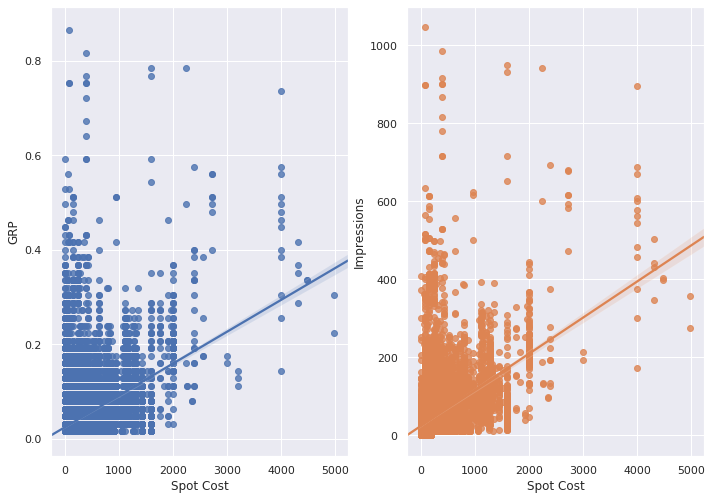

In [11]:
fig, ax = plt.subplots(1, 2)
sns.regplot(x=training["Spot Cost"], y=training["GRP"], data=training, ax=ax[0])
sns.regplot(x=training["Spot Cost"], y=training["Impressions"], data=training, ax=ax[1])

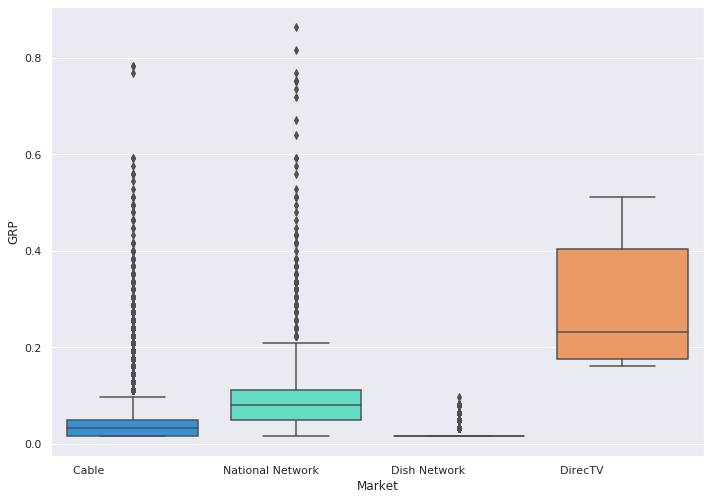

In [12]:
sns.boxplot(x=training["Market"], y=training["GRP"], data=training, palette="rainbow")

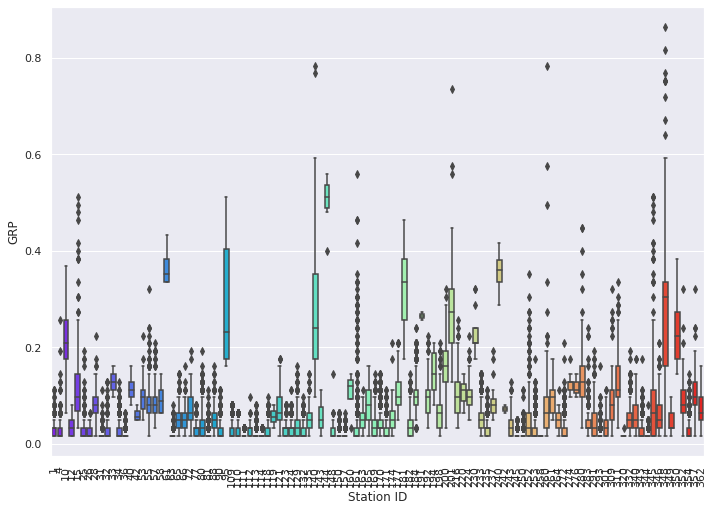

In [13]:
box = sns.boxplot(x=training["Station ID"], y=training["GRP"], data=training, palette="rainbow")
box.set_xticklabels(box.get_xticklabels(), rotation=90)
plt.show()

## Model Training

### Linear Regression

In [14]:
dat = pd.concat([dat, pd.get_dummies(dat["Estimate"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Access"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Market"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["DOW"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["daypart"], drop_first=True)], axis=1)
dat.columns

Index(['Access', 'DMA', 'Date Aired', 'Estimate', 'GRP', 'Impressions',
       'Length', 'Market', 'Media', 'Spot Cost', 'Spot Type', 'Station ID',
       'Time Aired', 'DOW', 'daypart', 'Q219', 'Q319', 'Q419', '15GD', '15PN',
       '30BP', '30DE', '30DP', '30GD', '30GX', '30PL', '30PM', '30PT', '30SR',
       '30TN', '30VE', 'SV15', 'DirecTV                       ',
       'Dish Network                  ', 'National Network              ',
       'Over-the-top content          ', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Early Fringe', 'Late Fringe',
       'Late Night', 'Morning', 'Overnight', 'Primetime'],
      dtype='object')

In [15]:
dat = dat.rename(columns=lambda x: x.strip())
dat.columns

Index(['Access', 'DMA', 'Date Aired', 'Estimate', 'GRP', 'Impressions',
       'Length', 'Market', 'Media', 'Spot Cost', 'Spot Type', 'Station ID',
       'Time Aired', 'DOW', 'daypart', 'Q219', 'Q319', 'Q419', '15GD', '15PN',
       '30BP', '30DE', '30DP', '30GD', '30GX', '30PL', '30PM', '30PT', '30SR',
       '30TN', '30VE', 'SV15', 'DirecTV', 'Dish Network', 'National Network',
       'Over-the-top content', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'Early Fringe', 'Late Fringe', 'Late Night',
       'Morning', 'Overnight', 'Primetime'],
      dtype='object')

In [16]:
unseen = dat[(dat.Impressions.eq(0.0)) & (dat.GRP.eq(0.0))]
training = dat[dat.GRP > 0.0]

X = training.loc[
    :,
    [
        "Length",
        "Spot Cost",
        "Q219",
        "Q319",
        "Q419",
        "15GD",
        "15PN",
        "30BP",
        "30DE",
        "30DP",
        "30GD",
        "30GX",
        "30PL",
        "30PM",
        "30PT",
        "30SR",
        "30TN",
        "30VE",
        "SV15",
        "DirecTV",
        "Dish Network",
        "National Network",
        "Over-the-top content",
        "Sunday",
        "Thursday",
        "Tuesday",
        "Wednesday",
        "Early Fringe",
        "Late Fringe",
        "Late Night",
        "Morning",
        "Overnight",
        "Primetime",
    ],
]
y = training.loc[:, "GRP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [17]:
lr = LinearRegression()

lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_preds)

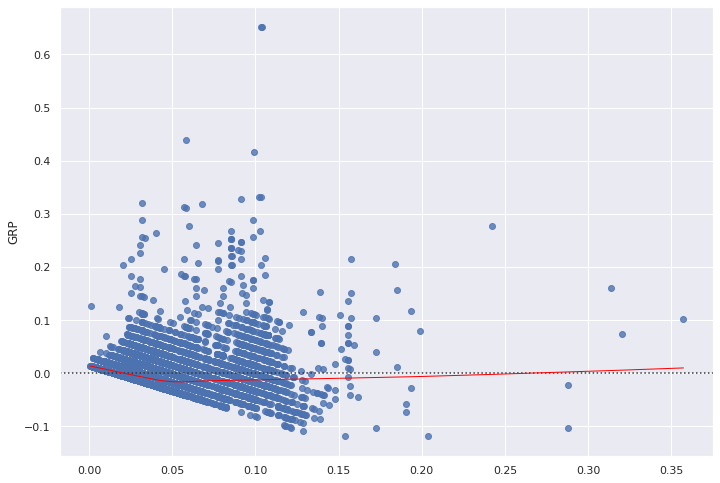

In [18]:
sns.residplot(
    lr_preds.reshape(-1),
    y_test,
    lowess=True,
    line_kws={"color": "red", "lw": 1, "alpha": 1},
)

Text(0.5, 1.0, 'Normal Q-Q Plot')

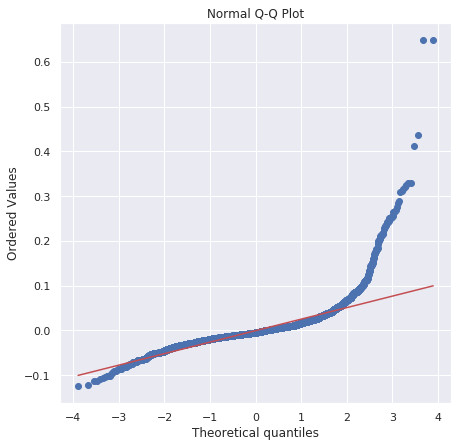

In [19]:
residuals = y_test - lr_preds.reshape(-1)
residuals

plt.figure(figsize=(7, 7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

In [20]:
lr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

### XGBoost Regressor

In [21]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

[01:22:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [22]:
xgb_preds = xgb.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_preds)

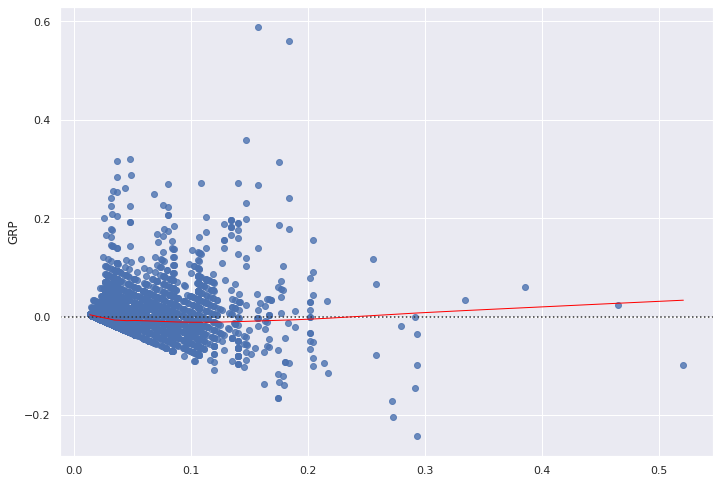

In [23]:
sns.residplot(
    xgb_preds.reshape(-1),
    y_test,
    lowess=True,
    line_kws={"color": "red", "lw": 1, "alpha": 1},
)

Text(0.5, 1.0, 'Normal Q-Q Plot')

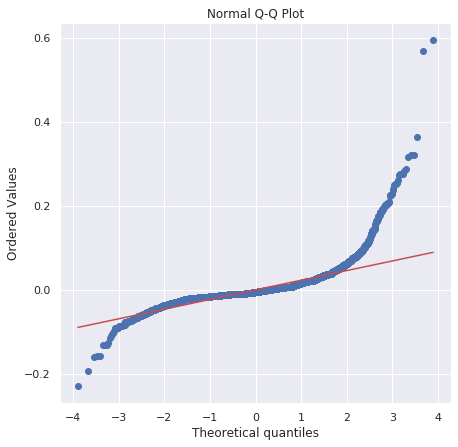

In [24]:
residuals = y_test - xgb_preds.reshape(-1)
residuals

plt.figure(figsize=(7, 7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

### Outlier Stations

In [25]:
dat['month'] = pd.DatetimeIndex(dat['Date Aired']).month
dat['month'] = dat['month'].apply(lambda x: calendar.month_name[x])

#### Outliers by Impressions

In [26]:
station_averages = dat.groupby(['month', 'Station ID']).mean().reindex(level=1)
monthly_averages = dat.groupby('month').mean().iloc[:, :-1]

In [27]:
total_averages = station_averages.join(monthly_averages,
                                       on='month', rsuffix='_monthly_averages')

#### Example 1: Find outlier stations in January using January average for Impressions

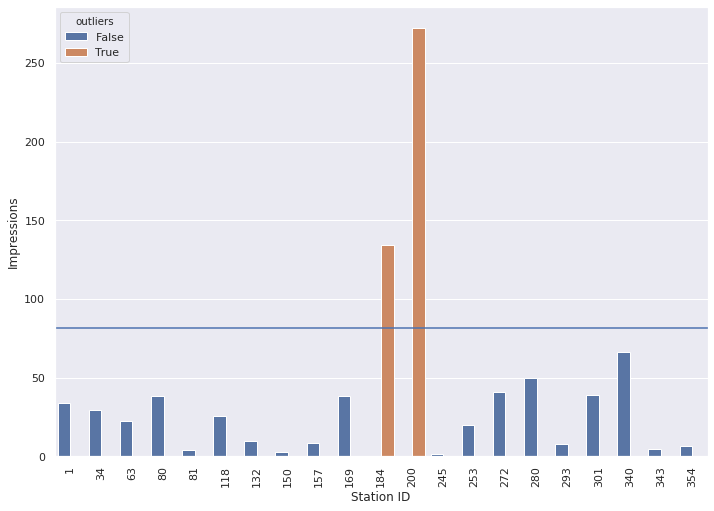

In [28]:
january = total_averages.iloc[total_averages.index.get_level_values('month')=='January']
january = january[january['Impressions'].notnull() & january['Impressions']>0]
january['outliers'] = np.where(january['Impressions'] < 2*january['Impressions'].mean(), False, True)
box = sns.barplot(x=january.index.get_level_values('Station ID'), y=january['Impressions'], 
                  data=january, palette=sns.color_palette(), hue='outliers')
line = box.axhline(2*january['Impressions'].mean())
box.set_xticklabels(box.get_xticklabels(), rotation=90)
plt.show()

#### Example 2: Using GRP

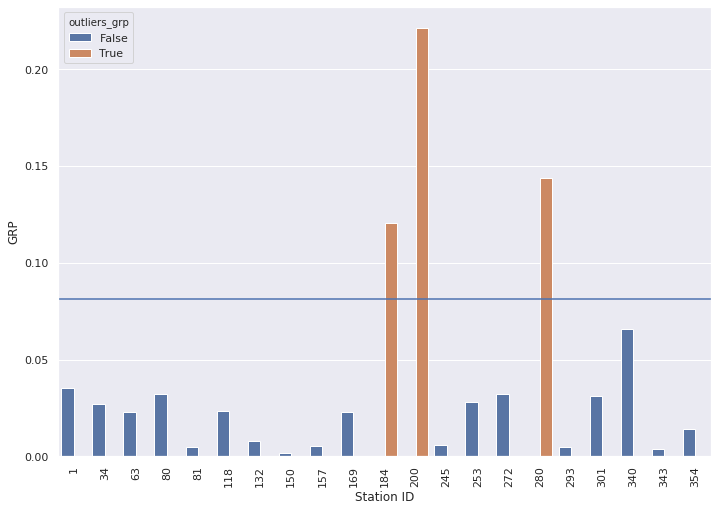

In [32]:
january['outliers_grp'] = np.where(january['GRP'] < 2*january['GRP'].mean(), False, True)
box = sns.barplot(x=january.index.get_level_values('Station ID'), y=january['GRP'], 
                  data=january, palette=sns.color_palette(), hue='outliers_grp')
line = box.axhline(2*january['GRP'].mean())
box.set_xticklabels(box.get_xticklabels(), rotation=90)
plt.show()

In [44]:
january[(january.outliers == True) & (january.outliers_grp == True)]

GRP  Impressions  Length   Spot Cost  Q219  Q319  \
month   Station ID                                                          
January 184         0.120308   134.450000    30.0   49.230769   0.0   0.0   
        200         0.221176   272.177778    30.0  588.705882   0.0   0.0   

                    Q419  15GD  15PN  30BP  ...  Tuesday_monthly_averages  \
month   Station ID                          ...                             
January 184          0.0   0.0   0.0   0.0  ...                  0.164099   
        200          0.0   0.0   0.0   0.0  ...                  0.164099   

                    Wednesday_monthly_averages  Early Fringe_monthly_averages  \
month   Station ID                                                              
January 184                           0.184223                       0.162301   
        200                           0.184223                       0.162301   

                    Late Fringe_monthly_averages  Late Night_monthly_averages  \
month   Station ID                                                              
January 184                             0.075077                      0.03282   
        200                             0.075077                      0.03282   

                    Morning_monthly_averages  Overnight_monthly_averages  \
month   Station ID                                                         
January 184                         0.102924                    0.051124   
        200                         0.102924                    0.051124   

                    outliers  global_outliers  outliers_grp  
month   Station ID                                           
January 184             True             True          True  
        200             True             True          True  

[2 rows x 77 columns]